# Анализ Бизнес -показателей. Яндекс.Афиша.

**Цель проекта** - провести анализ данных сервиса Яндекс.Афиша для определения основных метрик и формулировки предложений о перераспределении бюджета (отказ от менее эффективных каналов привлечение в пользу более эффективных).

**Данные:**

Выгрузки данных  Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

**Основные вопросы проекта:**
- как клиенты пользуются сервисом?
- когда делают первые покупки на сайте?
- сколько денег приносит компании каждый клиент?
- когда расходы на привлечение клиента окупаются?

### Содержание:

1. [Преобразование данных](#section_1)
2. [Продуктовые метрики](#section_2)
    * 2.1 [DAU, WAU, MAU](#section_2_1)
    * 2.2 [Сколько раз за день пользователи в среднем заходят на сайт](#section_2_2)
    * 2.2 [Продолжительность пользовательской сессии](#section_2_3)
    * 2.3 [Когортный анализ и расчет Retention Rate](#section_2_4)
3. [Метрики электронной коммерции](#section_3)
    * 3.1 [Время с первого захода на сайт до покупки](#section_3_1)
    * 3.2 [Среднее количество покупок на одного покупателя](#section_3_2)
    * 3.3 [Рассчет среднего чека](#section_3_3)
    * 3.4 [LTV](#section_3_4)
4. [Маркетинговые метрики](#section_4)
    * 4.1 [Рассчет расходов на маркетинг](#section_4_1)
    * 4.2 [CAC](#section_4_2)
    * 4.3 [ROMI](#section_4_3)
5. [Общий вывод](#section_5)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
visits = pd.read_csv(r"C:\Users\79520\OneDrive\Рабочий стол\проекты YP\Анализ бизнес показателей\visits_log.csv")
orders = pd.read_csv(r"C:\Users\79520\OneDrive\Рабочий стол\проекты YP\Анализ бизнес показателей\orders_log.csv")
costs = pd.read_csv(r"C:\Users\79520\OneDrive\Рабочий стол\проекты YP\Анализ бизнес показателей\costs.csv")

## 1. Преобразование данных.<a class="anchor" id="section_1">
    

In [3]:
#приведем поля к нужному формату
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [4]:
#приведем названия столбцов к единому формату
visits = visits.rename(
columns ={'Device':'device','End Ts':'session_end_ts','Source Id':'source_id','Start Ts':'session_start_ts','Uid':'uid'
}
)
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

orders = orders.rename(
columns = {'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'}
)


In [5]:
# #выделим месяц, неделю и дату визита в отдельный столбец
# visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
# visits['session_week'] = visits['session_start_ts'].astype('datetime64[W]')
# visits['session_date'] = visits['session_start_ts'].dt.date
# display(visits.head(5))


In [6]:
# проверим данные на наличие дубликатов 
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())


print(visits.isnull().sum())
print(orders.isnull().sum())
print(costs.isnull().sum())


0
0
0
device              0
session_end_ts      0
source_id           0
session_start_ts    0
uid                 0
dtype: int64
buy_ts     0
revenue    0
uid        0
dtype: int64
source_id    0
dt           0
costs        0
dtype: int64


### Вывод:

Необходимые данные представлены в трех таблицах: информация о визитах, оплатах и стоимости. Поля с временем были приведены к соответсвующему вормату для дальнейшей работы, столбцы переименованы с учетом единого формата. Данные проверены на наличие дубликатов и пропусков, дополнительная предобработка не требуется.

## 2. Продуктовые метрики.<a class="anchor" id="section_2">


### 2.1.DAU, WAU, MAU <a class="anchor" id="section_2_1">

На данном этапе исследования рассчитаем количество уникальных пользователей за день, неделю и месяц.

In [7]:
#прежде чем приступать к рассчетам выделим в отдельные год месяц недель пользовательской сесии
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'])
visits['session_year']  = visits['session_start_ts'].dt.year
visits['session_month'] = visits['session_start_ts'].dt.month
visits['session_week']  = visits['session_start_ts'].dt.week
visits['session_date'] = visits['session_start_ts'].dt.date

In [8]:
# рассчитаем количество уникальных пользователей за день, неделю и месяц - метрики DAU, WAU, MAU
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean().round(1)
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean().round(1)
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean().round(1)

In [9]:
print('DAU =', dau_total)
print('WAU =', wau_total)
print('MAU =', mau_total)

DAU = uid    908.0
dtype: float64
WAU = uid    5716.2
dtype: float64
MAU = uid    23228.4
dtype: float64


In [10]:
#зададим параметры для построения последующих графиков
sns.set(rc={'figure.figsize':(20,10)}, color_codes=True, font_scale=1.3,  palette='deep',)
# sns.color_palette("RdBu", n_colors=7);

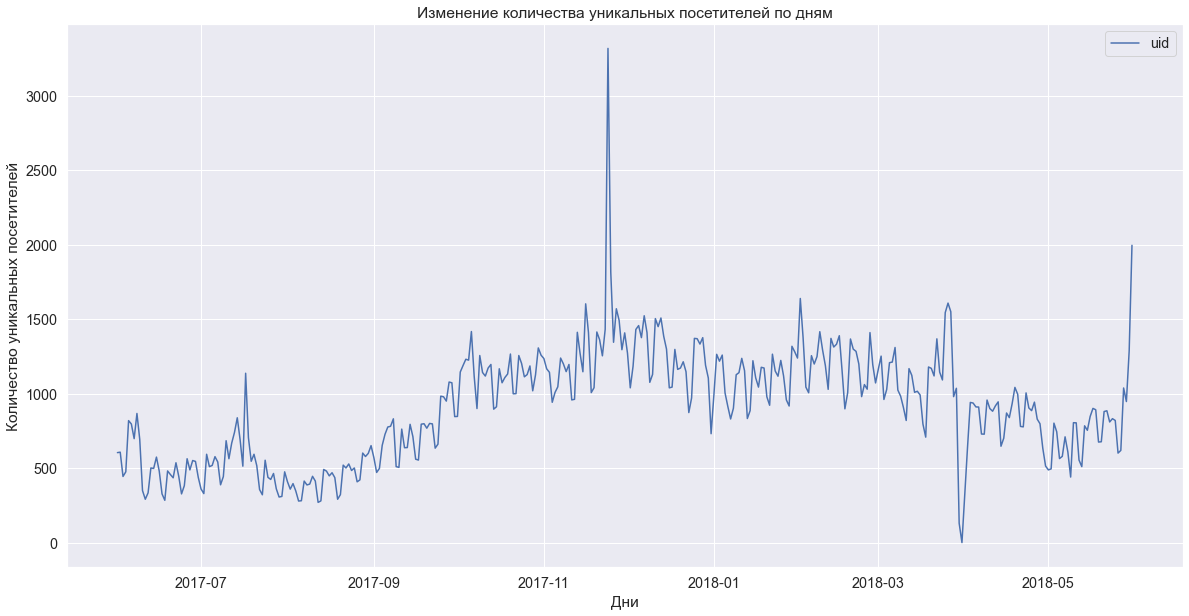

In [11]:
dau_plot = visits.groupby( ['session_date']).agg({'uid': 'nunique'})
dau_plot.plot()
plt.xlabel("Дни")
plt.ylabel("Количество уникальных посетителей")
plt.title("Изменение количества уникальных посетителей по дням");

При анализе графика изменения количества уникальных посетителей по дням можем выделить двв явно отклоняющихся значения - пик и просадка, определим даты отсортировав фрейм.

In [12]:
dau_plot['uid'].sort_values(ascending = False)

session_date
2017-11-24    3319
2018-05-31    1997
2017-11-25    1817
2018-02-01    1640
2018-03-26    1609
              ... 
2017-08-13     281
2017-08-05     280
2017-08-12     271
2018-03-30     131
2018-03-31       1
Name: uid, Length: 364, dtype: int64

Дата пика - 2017-11-24, просадка- 2018-03-31. Пик скорее всего связан с марктинговой акцией проводимой в этот день, просадка вероятнее всего обусловлена тех. работами на сервисе, полагаю, что сервис не был доступен.

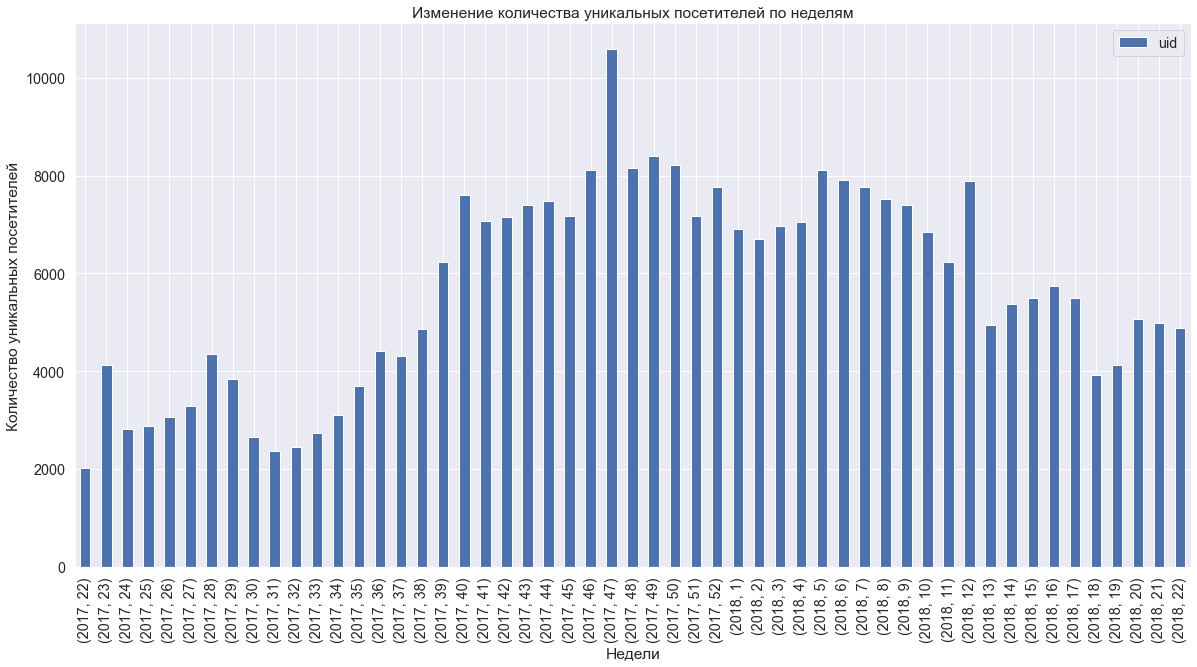

In [13]:
#построим график для изменения метрики WAU во времени
wau_plot = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
wau_plot.plot(kind ='bar', y ='uid')
plt.xlabel("Недели")
plt.ylabel("Количество уникальных посетителей")
plt.title("Изменение количества уникальных посетителей по неделям");

На графике изменения количества уникальных посетителей по неделям видим так же пиковые значения и просадки. Максимальный пик в ту же неделю, что и пик по дневным посещениям, связанный с проведенной маркетинговой акцией. Так же можем заметить, определенную цикличность в проводимых рекламных компаниях. Недели 23,2017; 29,2017; 41, 2017.

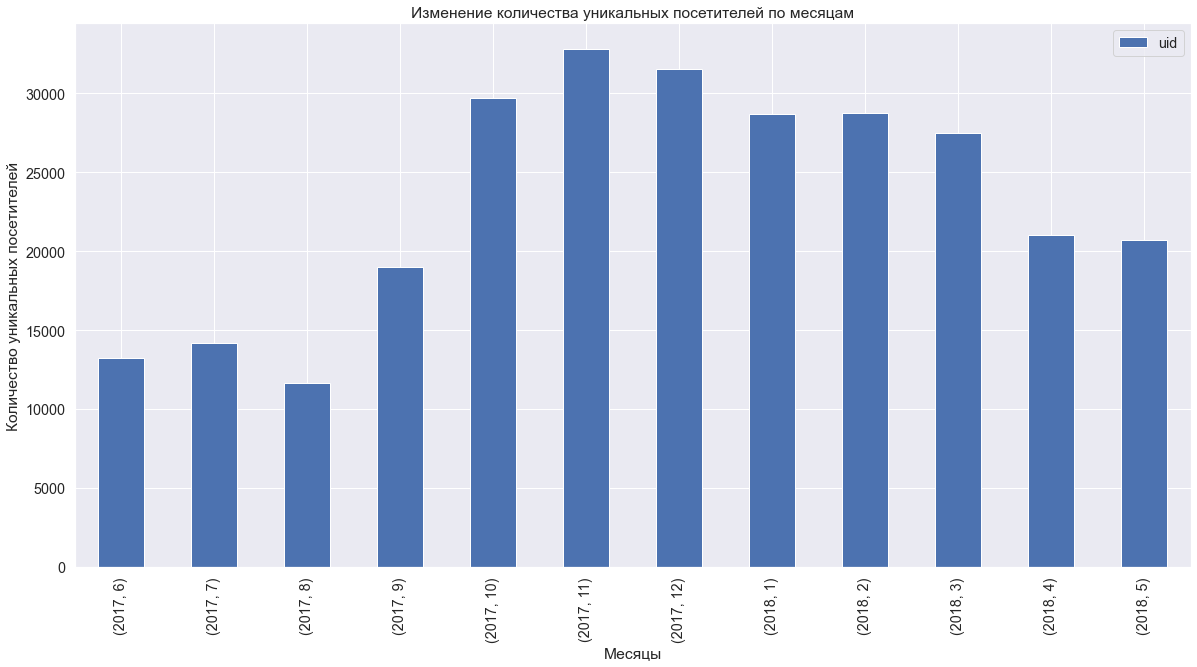

In [14]:
#построим график для изменения метрики MAU во времени
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
mau_plot = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
mau_plot.plot(kind = 'bar', y = 'uid');
plt.xlabel("Месяцы")
plt.ylabel("Количество уникальных посетителей")
plt.title("Изменение количества уникальных посетителей по месяцам");



На графике изменения количества уникальных посетителей по месяцам можем проследить сезонную цикличность. Возрастание спроса осенью и зимой. 

### Вывод.

В среднем за день сервисом пользуются 908 человек. В неделю 5716.2 и 23228.4 в месяц. Определенно повышение посящаемости за рассматриваемый период наблюдается ноябрь - декабрь 2017 года. 

### 2.2 Сколько раз за день пользователи в среднем заходят на сайт.<a class="anchor" id="section_2_2">

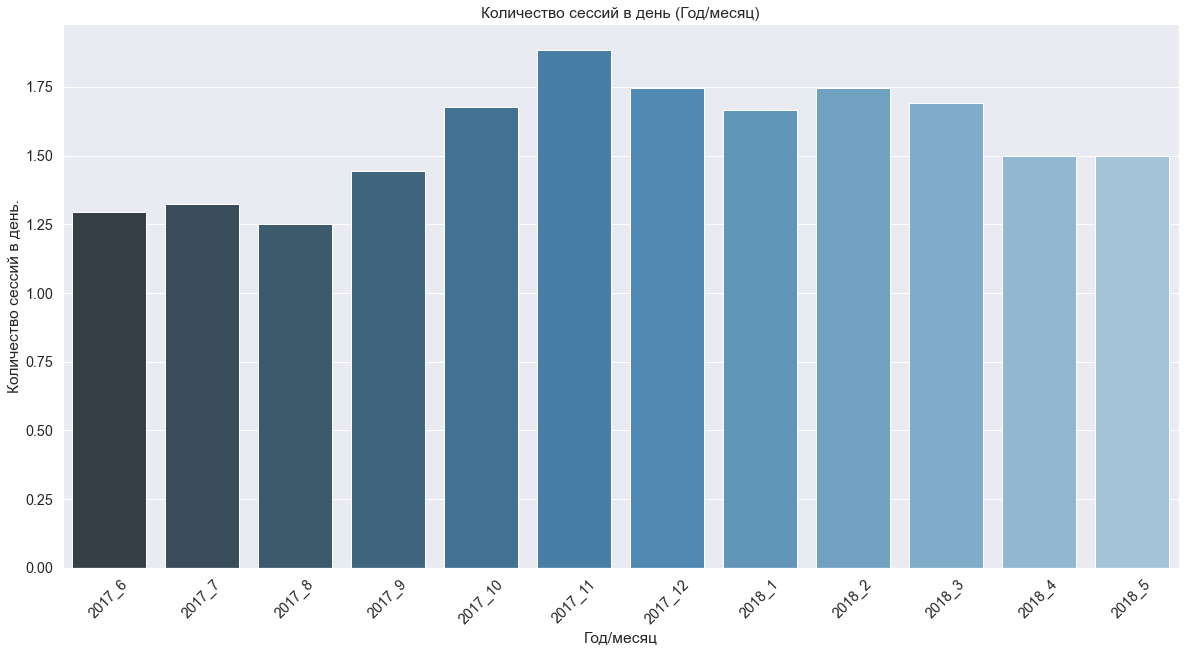

In [15]:
#сгруппируем данны и построи график для определения изменения метрики по месяцам
sessions = visits.groupby(['session_year', 'session_month', 'session_week', 'session_start_ts']).agg({'uid': ['count','nunique']}).reset_index()
sessions.columns = ['session_year','session_month','session_week', 'session_start_ts','n_sessions', 'n_users']
sessions['sessions_per_user'] = sessions['n_sessions'] / sessions['n_users']

sessions['year_month'] = sessions['session_year'].apply(str) + '_' + sessions['session_month'].apply(str)
sessions_grouped = sessions.groupby('year_month')['n_sessions'].mean().reset_index()

day_order = ['2017_6','2017_7', '2017_8', '2017_9', '2017_10','2017_11', '2017_12', '2018_1', '2018_2', '2018_3','2018_4','2018_5']
sns.barplot(x = 'year_month', y = 'n_sessions', data = sessions_grouped, order = day_order, palette = 'Blues_d')
plt.xticks(rotation=45)
plt.xlabel('Год/месяц')
plt.ylabel('Количество сессий в день.')
plt.title('Количество сессий в день (Год/месяц)');

На графике изменения количества сессий по месяцам видим явный рост активности 2017_17 в среднем количество сессий не привышает двух.


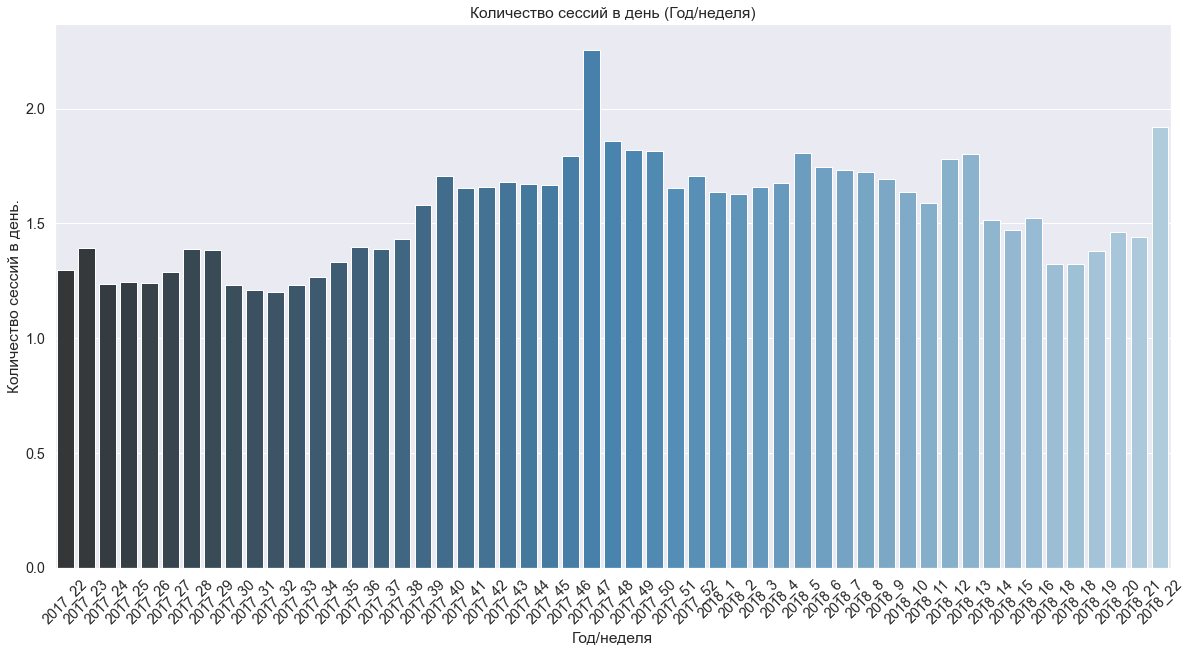

In [16]:
#сгруппируем данны и построи график для определения изменения метрики по неделям

sessions['year_week'] =   sessions['session_year'].apply(str)+ '_' +sessions['session_week'].apply(str)  

sessions_grouped = sessions.groupby('year_week')['n_sessions'].mean().reset_index()
sessions_grouped.sort_values(by ='year_week')

# задаем порядок недель по оси x руками т.к. автоматически проставляются некоректные значения
week_order = ['2017_22', '2017_23', '2017_24', '2017_25', '2017_26', '2017_27', '2017_28', '2017_29', '2017_30', '2017_31','2017_32','2017_33','2017_34','2017_35', '2017_36', '2017_37', '2017_38','2017_39', '2017_40', '2017_41', '2017_42', '2017_43','2017_44','2017_45','2017_46','2017_47', '2017_48', '2017_49', '2017_50','2017_51', '2017_52', '2018_1', '2018_2', '2018_3','2018_4','2018_5','2018_6','2018_7', '2018_8', '2018_9', '2018_10','2018_11', '2018_12', '2018_13', '2018_14', '2018_15','2018_16','2018_18','2018_18','2018_19', '2018_20', '2018_21', '2018_22']

#используем все тот же barplot т.к. можем регулировать параметр order
sns.barplot(x = 'year_week', y = 'n_sessions', data = sessions_grouped, palette = 'Blues_d', order = week_order)
plt.xticks(rotation=45)
plt.xlabel('Год/неделя')
plt.ylabel('Количество сессий в день.')
plt.title('Количество сессий в день (Год/неделя)');

В разрезе недель видим примерно следующю картину, количестов сессий максимаоьно на 27.ю неделю 2017 го года, так же имеется определенный пик 22_2018.

In [17]:
# так же рассчитаем общий показатель - срденее количество сессий на пользователя 
sessions['sessions_per_user'].mean()

1.0000014860850428

### Вывод.

За рассматриваемый период, если анализировать среднее количесво посещений пользователей в день в разрезе месяце, можно выделить определенные пики: 11.2017 и 02.2018. 06.2017 - 08.2017 наблюдается определенная просадка. 

Можно связать с тем, что в летнее время пользователи посещяют сервис реже предпочитая отдых на открытом воздухе и прогулки. 

В разрезе недель видим явные пики совпадающие с пиками по количествам уникальных посетителей. Период с 20 по 26 ноября был однозначно самым загруженным для сервиса за рассматриваемый период.

### 2.3 Продолжительность пользовательской сессии.<a class="anchor" id="section_2_3">

In [18]:
#рассчитаем время сессии для каждого пользователя
visits['session_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds

min = (visits['session_duration_sec'].mean())/60

#сразу определим моду
mode = visits['session_duration_sec'].mode()

print('Средняя продолжительность сессии: {:.0f} секунды'.format(visits['session_duration_sec'].mean())) 
print('Мода продолжительности сессии: {:.0f} секунд'.format(mode.values[0]))

Средняя продолжительность сессии: 644 секунды
Мода продолжительности сессии: 60 секунд


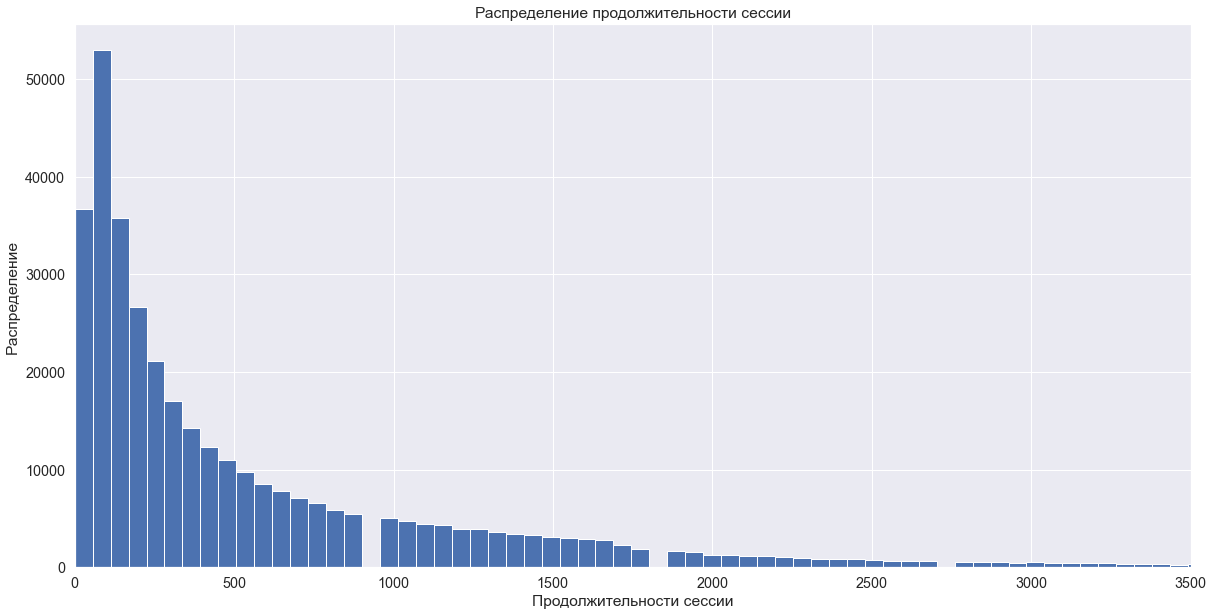

In [19]:
# построим гистограмму распределения продолжительности сессии
visits['session_duration_sec'].plot(kind = 'hist', bins = 1500)
plt.xlim(0,3500);
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительности сессии')
plt.ylabel('Распределение ');

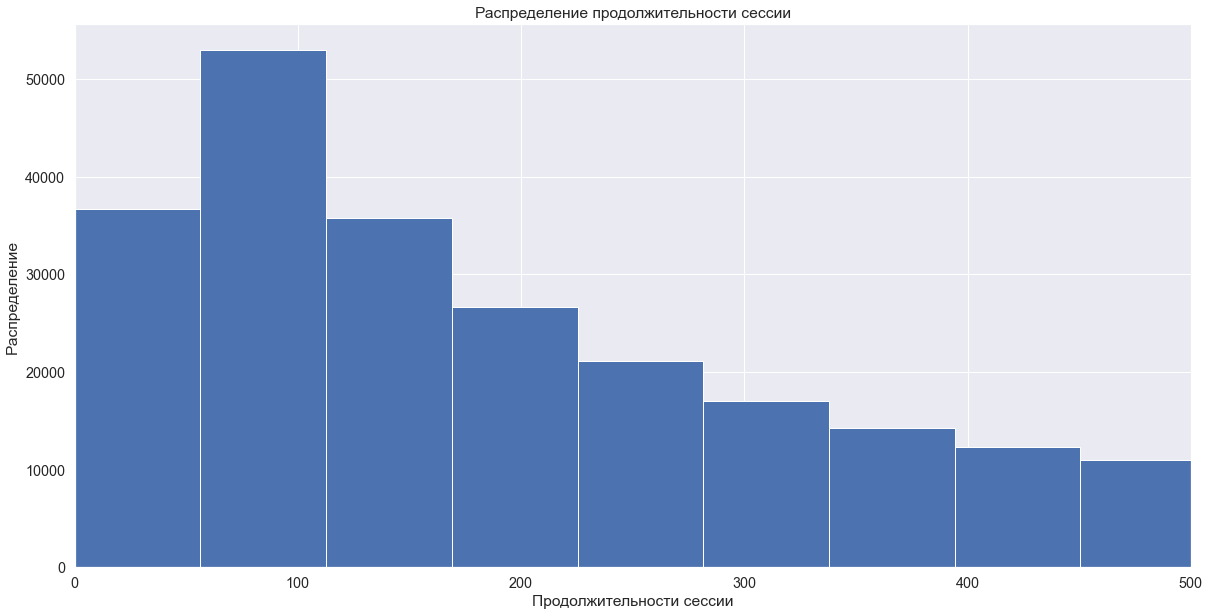

In [20]:
# рассмотри более детально период от 0 до 500 сек
visits['session_duration_sec'].plot(kind = 'hist', bins = 1500)
plt.xlim(0,500);
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительности сессии')
plt.ylabel('Распределение ');

In [21]:
# по гистограммам видим, что фрейм имеет большое количество выбросов, посчитаем медиану, более устоючивую к выбросам
print('Медиана продолжительности сессии:', visits['session_duration_sec'].median())

Медиана продолжительности сессии: 300.0


### Вывод:

Медианное значение меньше среднего в два раза, что говорит о большом влиянии крайних показателей. 
Целесообразно в дальнешем учитывть именно медианный показатель. В среднем пользователь на странице проводит 5 минут. Так же необходимо принимать в расчет, тот факт что, наиболее часто встречающееся значение - 1 минут. 
Можем сделать вывод, что в среднем пользователь проводит на сайте от 1 до 5 минут.

#### 2.4 Когортный анализ и рассчет Retention Rate <a class="anchor" id="section_2_4">

In [22]:
#для построения когортного анализа выделим дату и время первой сесси каждого пользователя
first_visits = visits.groupby('uid').agg({'session_start_ts':'min'}).reset_index()
first_visits.columns = ['uid','first_session_start_ts']
first_visits 


,uid,first_session_start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228164,18446403737806311543,2017-11-30 03:36:00
228165,18446424184725333426,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00
228167,18446621818809592527,2017-12-27 13:27:00


In [23]:
#добавляем поля даты и месяца для группировки
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')
first_visits.head(5)

,uid,first_session_start_ts,first_session_dt,first_session_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01


In [24]:
#повторно приведем нужные поля к формату даты
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['session_start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['session_start_ts'].dt.date

#добавляем инфомрацию о первом визите в датафрейм с посеитетлями
vis = pd.merge(first_visits, visits, on = 'uid')

# сколько времени прошло между каждой сессией и первой сессией пользователя
vis['age_months'] = ((vis['session_month'] - vis['first_session_month'])/np.timedelta64(1,'M')).round().astype('int')
vis.head(5)

,uid,first_session_start_ts,first_session_dt,first_session_month,device,session_end_ts,source_id,session_start_ts,session_year,session_month,session_week,session_date,session_duration_sec,age_months
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018,2018-03-01,2018-03-01,2018-03-01,360,0
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018,2018-02-01,2018-02-01,2018-02-06,120,0
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017,2017-06-01,2017-06-01,2017-06-07,60,0
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,2018,2018-03-01,2018-03-08,2018-03-11,360,6
4,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017,2017-09-01,2017-09-14,2017-09-18,1080,0


In [25]:
cohorts = vis.pivot_table(index = 'first_session_month',
                        columns = 'age_months',
                        values = 'uid',
                        aggfunc = 'nunique')
cohorts.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


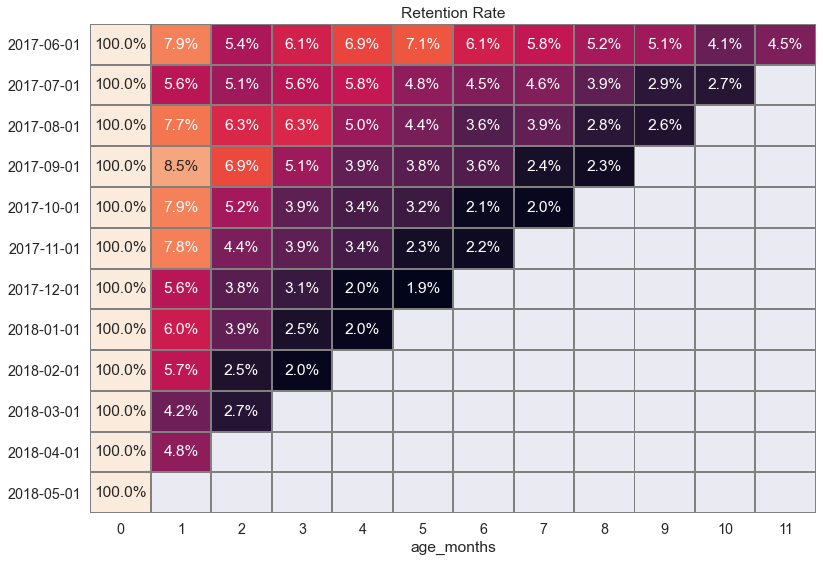

In [26]:
# Рассчет Ratention Rate
retention = pd.DataFrame()


for col in cohorts.columns:
     retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)
retention.columns = cohorts.columns
retention.index = [str(x)[0:10]for x in retention.index]

plt.figure(figsize = (13,9))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey', cbar=False, vmax = 0.1, cbar_kws = {'orientation':'horizontal'}
           ).set(title = 'Retention Rate')
plt.show()


In [27]:
# рассчитаем средний retention rate за второй месяц жизни когорт
print('Средний Retention Rate на второц месяц жизни когорт: {:.2%}'.format(retention[1].mean()))

Средний Retention Rate на второц месяц жизни когорт: 6.52%


In [28]:
retention[1].mean()

0.06516659710392834

### Вывод:

В текущем разделе был рассчитан retention rate - коэффциент удержания. Изучив тепловую карту можно увидет, что наиболее привлекательные показатели показывает первая когорта 2017 - 06- 01. На протежении рассматриваемого периода наибольший процент пользователей возвращался на сервис из месяца в месяц. Так же выделяется когорта 2017-09-01, во второй месяц жизни когорты перешли 8.5% пользователей, что является максимальным в за данный период. 

## 3 Метрики электронной коммерции <a class="anchor" id="section_3">

### 3.1 Время с первого захода на сайт до покупки<a class="anchor" id="section_3_1">

In [29]:
#добавление дня и месяца заказ,для рассчета суммарной выручки за периоды
orders['buy_dt'] = orders['buy_ts'].dt.date
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

#находим время первой покупки каждого покупателя
first_orders = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_orders.columns = ['uid','first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')
first_orders.head()

#объединяем данные о первых покупках с данными о первых сессиях
buyers = pd.merge(first_visits, first_orders, on='uid')

buyers.head(5)

,uid,first_session_start_ts,first_session_dt,first_session_month,first_order_ts,first_order_dt,first_order_month
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11-01


In [30]:
buyers['first_order_dt'] = pd.to_datetime(buyers['first_order_dt'])
buyers['first_session_dt'] = pd.to_datetime(buyers['first_session_dt'])

# рассчитаем время от первого захода на сайт до первой покупки
buyers['minutes_to_first_purchase'] = ((buyers['first_order_ts'] - 
                                    buyers['first_session_start_ts'])/np.timedelta64(1,'m')).astype('int')


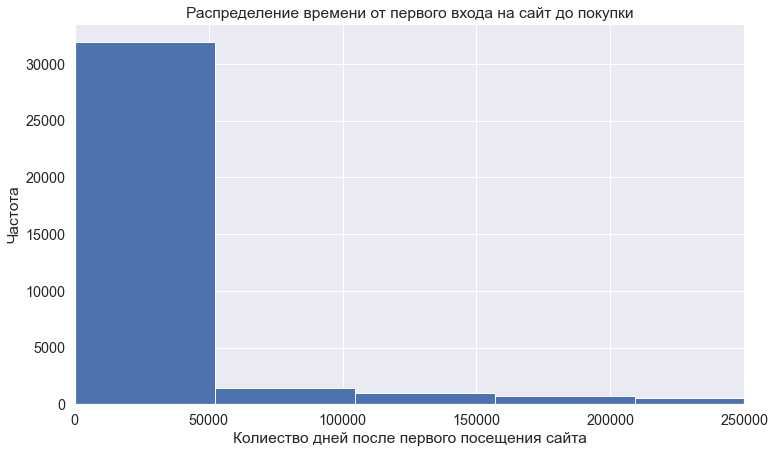

In [31]:
#построим гистограмму распределения времени от первого захода на сайт до покупки
(buyers['minutes_to_first_purchase'].plot(kind='hist', bins=10, figsize =(12,7))
                                .set(title = 'Распределение времени от первого входа на сайт до покупки',
                                xlabel = 'Колиество дней после первого посещения сайта',
                                ylabel = 'Частота'))

plt.xlim(0,250000)
plt.ylim()
plt.show()

In [32]:
print(buyers['minutes_to_first_purchase'].mean())
print(buyers['minutes_to_first_purchase'].mode())
print(buyers['minutes_to_first_purchase'].median())

24340.175834405716
0    1
dtype: int32
16.0


## Вывод.

В среднем от первого захода на сайт до пукупки проходит 16 дней. Самое часто вречаемое значение - 1 минута, медиана - 16 минут. Видим, что значения кардинально отличаются. Исоходя из харакетра распределения будем брать в расчет прежде всего моду и медианное значение. Считаем, что совершения покупеи пользователю необходимо от 1 до 16 минут проведенных на сайте.

На гистограмме видим изначительный пик на нулевом показателе. Отчасти пик может быть обусловлен вбросами.

### 3.2 Cреднее количество покупок на одного покупателя <a class="anchor" id="section_3_2">

In [33]:
#получим срез за первые пол года
orders_first_six_months = orders.query("buy_ts > '2017-06-01 00:00:00' & buy_ts < '2017-12-01 23:00:00'")

In [34]:
#сгруппируем количесво покупок по id посчитаем среднее количесво покупок  одним клиентом за пол года
orders_mean = orders_first_six_months.groupby('uid')['buy_ts'].count().mean()
orders_median = orders_first_six_months.groupby('uid')['buy_ts'].count().median()

print('Среднее количество покупок на одного пользователя за пол года: {:.2f}'.format(orders_mean))
print('Медиана количества покупок на одного пользователя за пол года:', orders_median)

Среднее количество покупок на одного пользователя за пол года: 1.30
Медиана количества покупок на одного пользователя за пол года: 1.0


### Вывод:

В среднем за рассматриваемый период - 6 месяцев, пользователь совершает 1.3 покупки. Медианно значение равно еденице. Информация говрит о том, что для сервиса выгодно привлекать как можно больш новых пользователей, а не делать акцент на существующих. 

### 3.3 Рассчет среднего чека <a class="anchor" id="section_3_3">

In [35]:
orders

,buy_ts,revenue,uid,buy_dt,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-01


In [36]:
revenue_average = orders.groupby('order_month')['revenue'].mean()
revenue_average1=revenue_average.reset_index()


print('Средний чек равен {:.2f}'.format(revenue_average1['revenue'].mean()), 'у.е.')

Средний чек равен 4.84 у.е.


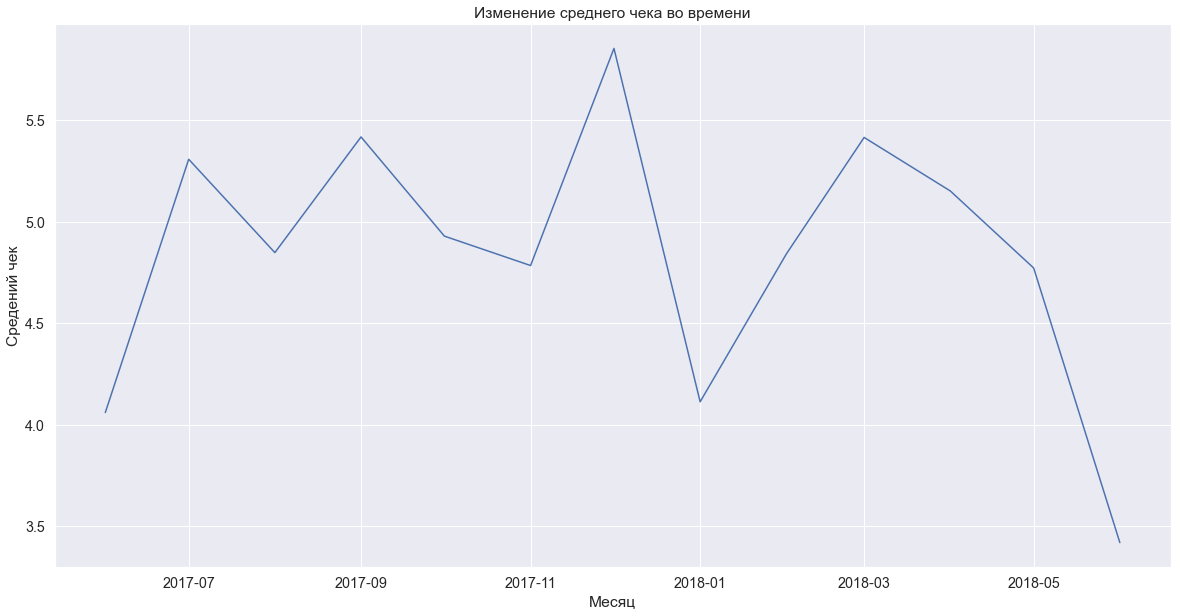

In [37]:
#рассчитаем средний чек, отобразим изменеие во времени
revenue_average = orders.groupby('order_month')['revenue'].mean()
sns.lineplot(data = revenue_average)
plt.xlabel('Месяц')
plt.ylabel('Средений чек')
plt.title('Изменение среднего чека во времени')
plt.show()

### Вывод:

Средний чек за изучаемый период равен 4.84 у.е. Если рассматривать изменеие среднего чека во времени, можно увидеть опреедленные пики до 5.85 2017.12 В течение месяца наблючаетс значительное изменние размера чека, пмаксимальная просадка  2018-01. Затем стремительный рост, пик в марте и вновь снижение. Такое поведение может быть обусловлено сезонными особенностяит поведеия покупателей. В особенности праздничными и выходными днями.

### 3.4 LTV <a class="anchor" id="section_3_4">

In [38]:
buyers

,uid,first_session_start_ts,first_session_dt,first_session_month,first_order_ts,first_order_dt,first_order_month,minutes_to_first_purchase
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,154022
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10-01,79
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01,1184
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11-01,0
...,...,...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-08-20,2017-08-01,2017-11-24 09:03:00,2017-11-24,2017-11-01,137973
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22,2017-09-01,2017-09-22 23:55:00,2017-09-22,2017-09-01,7
36520,18445601152732270159,2017-08-07 11:51:00,2017-08-07,2017-08-01,2018-03-26 22:54:00,2018-03-26,2018-03-01,333303
36521,18446156210226471712,2017-11-07 10:01:00,2017-11-07,2017-11-01,2018-02-18 19:34:00,2018-02-18,2018-02-01,148893


In [39]:
#строим когортный отчет от даты первой покупки для подсчета 
cohort_sizes = buyers.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid':'n_buyers'}, inplace = True)
cohort_sizes.head(5)

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [40]:
#добавлям информацию о покупках - месяц первой покупки
cohorts = pd.merge(orders, buyers, how='inner', on ='uid')\
.groupby(['first_order_month', 'order_month'])\
.agg({'revenue':'sum'}).reset_index()

cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [41]:
#Считаем возраст каждой когорты
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month'])/np.timedelta64(1,'M')).round()
cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'age_month']

#Добавляем в когоротный отчет количество покупателей в каждой когорте
# считаем выручку на каждого поукпателя

cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
cohorts_report['rev_per_buyer'] = cohorts_report['revenue']/cohorts_report['n_buyers']
cohorts_report.head(5)

,first_order_month,n_buyers,order_month,revenue,age_month,rev_per_buyer
0,2017-06-01,2023,2017-06-01,9557.49,0.0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1.0,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2.0,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3.0,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4.0,1.022531


In [42]:
first_visits['first_session_dt'] = first_visits['first_session_start_ts'].dt.date
first_visits['first_session_month'] = first_visits['first_session_start_ts'].astype('datetime64[M]')

In [43]:
cohorts_report['first_order_month'] =cohorts_report['first_order_month'].dt.to_period('M')

In [44]:
#выведем сводную таблицу по количеству покупок на одного покупателя
cohorts_age = cohorts_report.pivot_table(
    index='first_order_month',
    columns='age_month',
    values='rev_per_buyer',
    aggfunc = 'sum'
).cumsum(axis=1)

#выделим отдельно месяцы для лучшего визуального отображения
# cohorts_age['first_order_month'] = cohorts_age['first_order_month'].dt.to_period('M')
cohorts_age.round(2).fillna('')



age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02,4.16,4.44,4.51,4.59,,,,,,,,


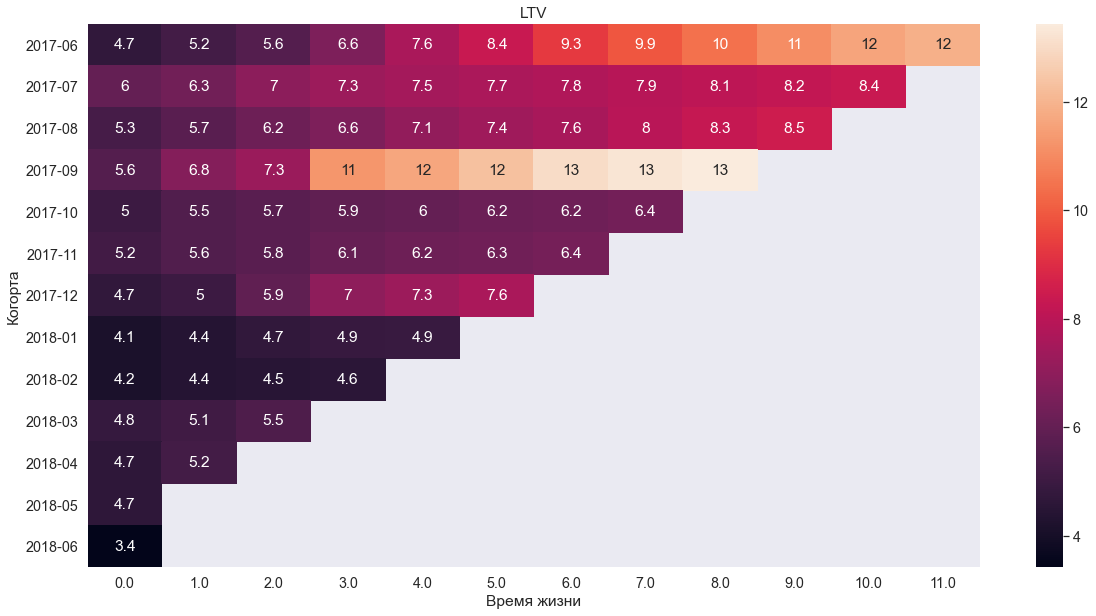

In [45]:
#для большей наглядности построим теплову карту
sns.heatmap(cohorts_age, annot=True)
plt.xlabel('Время жизни')
plt.ylabel('Когорта')
plt.title('LTV')
plt.show()

In [48]:
#рассчет среднего ltv за 6 месяцев
print('Средний ltv за 6 меяцев:{:.2f}'.format(cohorts_report.query('first_order_month<="2018-01" & age_month <=5').groupby('first_order_month').agg({'rev_per_buyer':'sum'})['rev_per_buyer'].mean()), 'y.e')

Средний ltv за 6 меяцев:7.59 y.e


### Вывод.

На данном этапе исследования был рассчитан показатель ltv - life time value, определяющий 'пожизненную' ценность клиента для компании. 
Из анализа тепловой карты видим, что когорта от 01.09.2017 значительно выделяется. пользователи из этой когороты приносят компании в среднем 11 y.e. уже на 4-й месяц жизни когорты.

Средний ltv за 6 меяцев: 7.59 y.e

Отметим, что при подсчете retention rate именно эта когорта показывала лучшие результаты за исследумый период.

## 4. Маркетинговые метрики <a class="anchor" id="section_4">

### 4.1 Рассчет расходов на маркетинг. <a class="anchor" id="section_4_1">

In [49]:
#посчитаем общую сумму расходов на маркетинг
print(costs['costs'].sum(), 'y.e')

329131.62 y.e


In [50]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


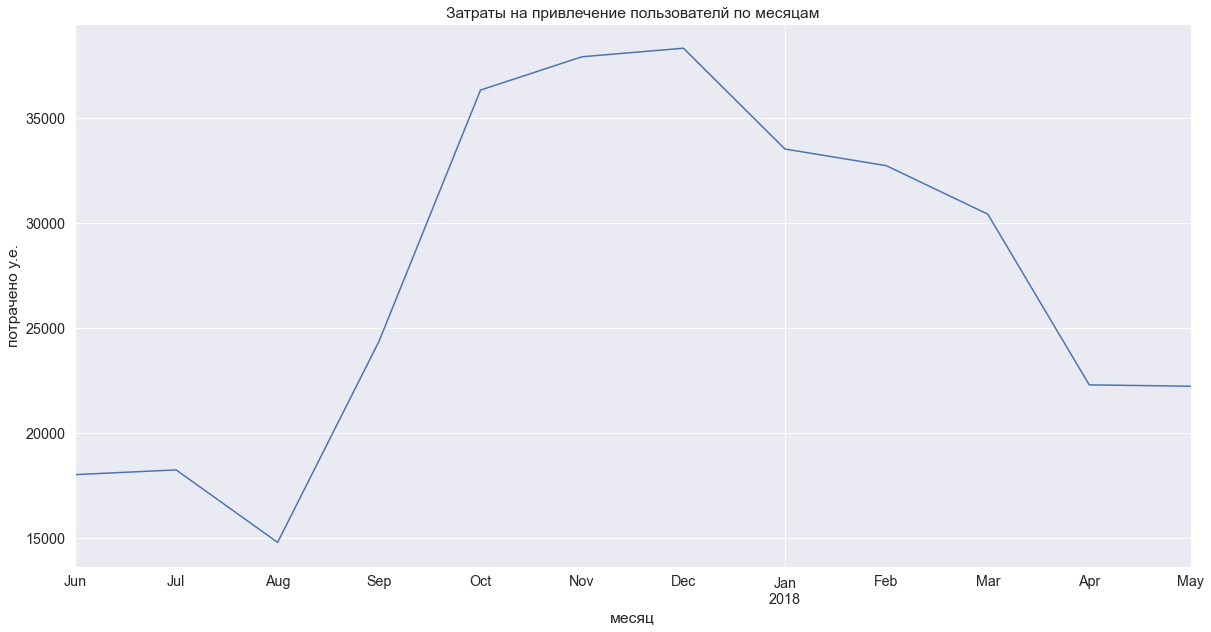

In [51]:
# Построим график отражающий суммарные затраты на привлчение по месяцам
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs_per_month = costs.groupby('costs_month')['costs'].sum()
costs_per_month.plot(kind = 'line');
plt.title('Затраты на привлечение пользователй по месяцам')
plt.xlabel('месяц')
plt.ylabel('потрачено y.e.');

На графике видим изменение суммарных расходов на привлечение пользователей. Рекламные кампании активно наращивались начиная с августа 2017. С декабря 2018 видим опредленный спад, может быть связано с переаспределением бюджета, оптимизаций маркетинговых расходов с точки зрения эффективности и стоимости трафика.

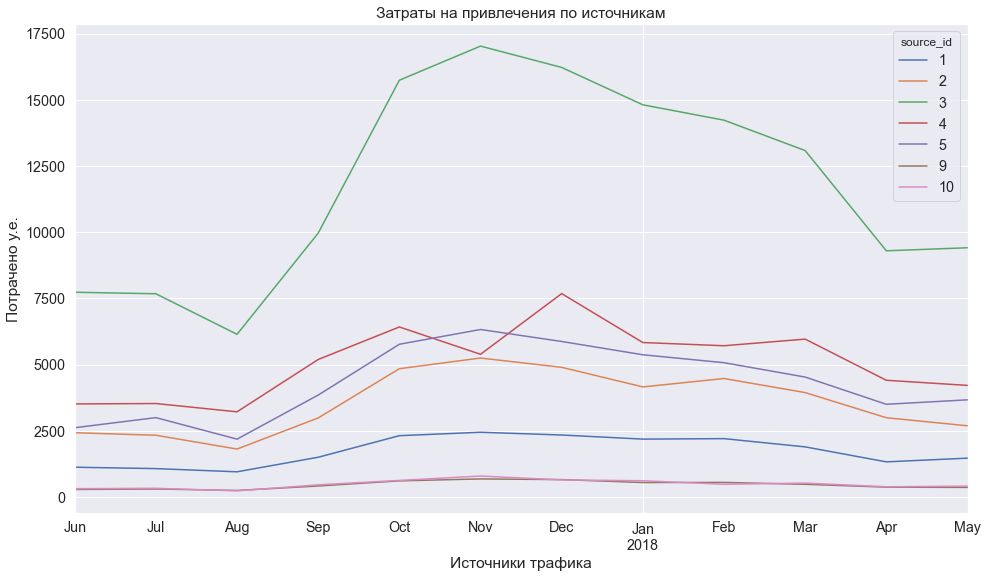

In [52]:
#так же построим грфик раходов на маркетинг по времени с учетом истоников
costs.pivot_table(index=['costs_month'], columns = 'source_id', values= 'costs', aggfunc = 'sum').plot(
    figsize = (16,9))
plt.xlabel('Источники трафика')
plt.ylabel('Потрачено y.e.')
plt.title('Затраты на привлечения по источникам')
plt.show()

При анализе графика можем заметить, что основная динамика в изменении общих расходов обусловлена расходами на источник №3. Затраты на остальные каналы привлечения изменялись в значительно меньшей степени, например, на источники 9 и 10 тратили примерно одну и ту же сумму на протяжении всего периода.

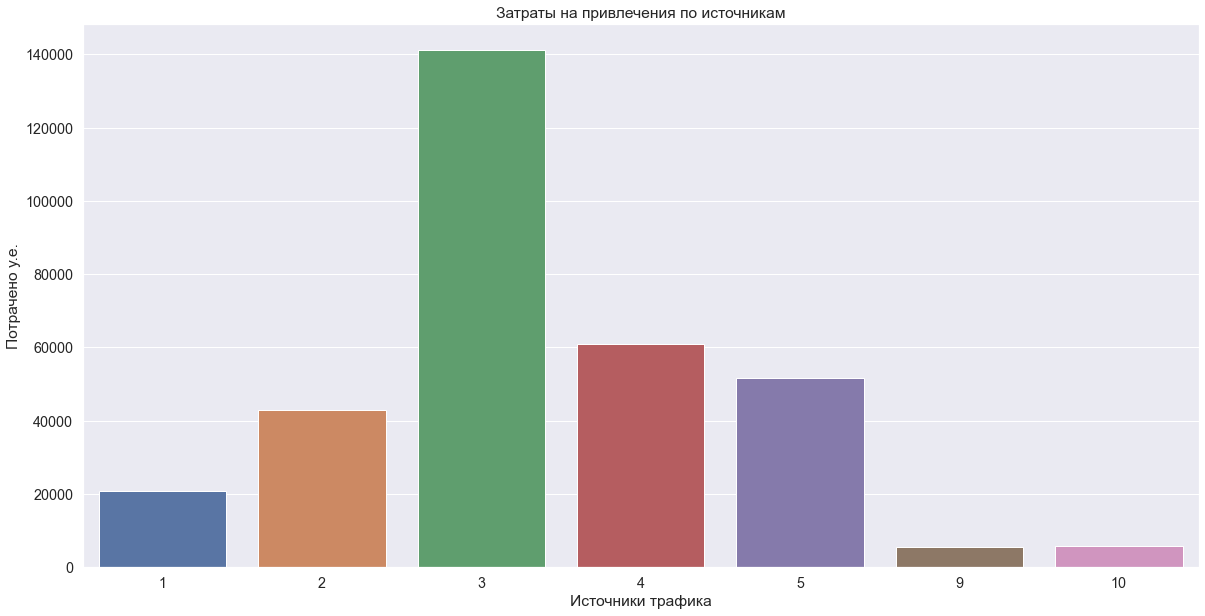

In [53]:
#cгруппируем расходы по источникам
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
sns.barplot(data = costs_by_source, x='source_id', y='costs')
plt.xlabel('Источники трафика')
plt.ylabel('Потрачено y.e.')
plt.title('Затраты на привлечения по источникам')
plt.show()

### Вывод:

Всего за изучаемый период на мркетинг было потрачено 329131.62 y.e ,наиболее затратным источником привлечения клиентов считаем источник #3. В целом потрачено около 14000 у.е. на привлечение пользователей по этому источнику.

Исходя из динамики изменения суммарных расходов наиболее завтраный период октябрь 2017 - январь 2018. В этот же период можем наблюдать нибольшую польлзовательскую активность.

### 4.2 CAC <a class="anchor" id="section_4_2">

In [54]:
#найдем первый рекламный источник , из которого пришел каждый пользователь
users = visits.sort_values('session_start_ts').groupby('uid').first()
users = users[['source_id']]
buyers = pd.merge(buyers, users, left_on ='uid', right_index = True)
buyers.head(5)

,uid,first_session_start_ts,first_session_dt,first_session_month,first_order_ts,first_order_dt,first_order_month,minutes_to_first_purchase,source_id
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,154022,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01,0,10
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10-01,79,3
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01,1184,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11-01,0,5


In [55]:
#группировка уникальных пользователей по источникам по первой дате покупки 
buyers_daily = buyers.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid':'n_buyers'}, inplace = True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])
buyers_daily.head(5)

,source_id,first_order_dt,n_buyers
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18


In [56]:
# расчитываем cac - стоимость одного клиента
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs_ = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_dt'], right_on=['source_id','dt'])
costs_['costs_per_buyer'] = costs_['costs']/costs_['n_buyers']
costs_.head(5)

,source_id,first_order_dt,n_buyers,dt,costs,costs_month,costs_per_buyer
0,1,2017-06-01,14,2017-06-01,75.20,2017-06-01,5.371429
1,1,2017-06-02,7,2017-06-02,62.25,2017-06-01,8.892857
2,1,2017-06-03,7,2017-06-03,36.53,2017-06-01,5.218571
3,1,2017-06-04,3,2017-06-04,55.00,2017-06-01,18.333333
4,1,2017-06-05,18,2017-06-05,57.08,2017-06-01,3.171111


In [60]:
# рассчитаем средний cac по проекту
print('Средний cac по проекту: {:.2f}'.format(costs_['costs_per_buyer'].mean()), 'y.e')

Средний cac по проекту: 10.19 y.e


In [61]:
# рассчитываем cac по источникам за весь период
costs_.groupby('source_id')['costs_per_buyer'].mean()

source_id
1      9.489732
2     16.287024
3     15.580474
4      7.271743
5      8.336731
9      6.842532
10     6.555415
Name: costs_per_buyer, dtype: float64

In [62]:
#cac по источникам во времени
сac_source = costs_.pivot_table(index = ['costs_month'], columns ='source_id', values ='costs_per_buyer', aggfunc = 'mean')

In [63]:
сac_source

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


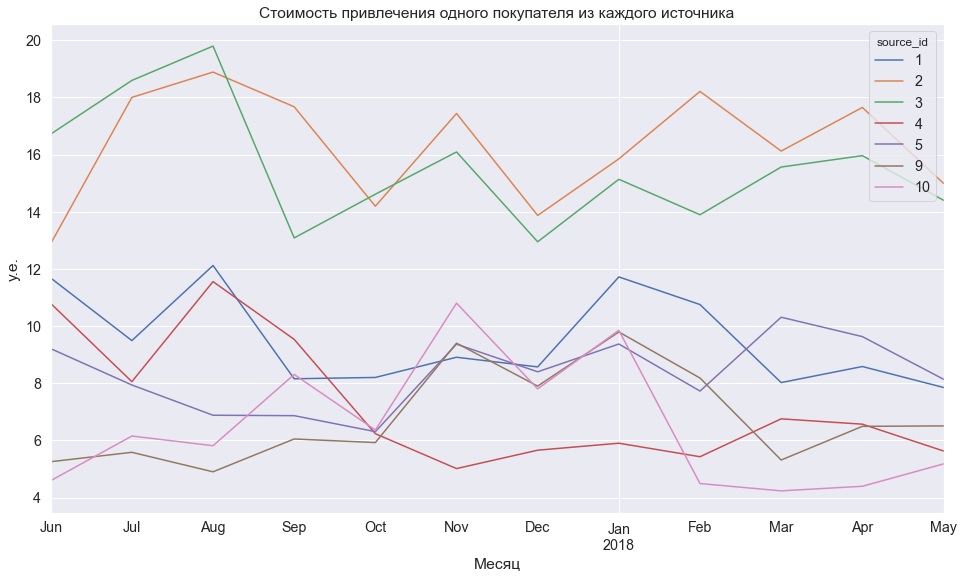

In [64]:
costs_.pivot_table(index=['costs_month'], columns = 'source_id', values= 'costs_per_buyer', aggfunc = 'mean').plot(
    figsize = (16,9)).set(title = 'Cтоимость привлечения одного покупателя из каждого источника',
                         xlabel = 'Месяц',
                         ylabel = 'y.e.')

plt.show()

### Вывод:

На данном этапе была расчитана метрика customer acquisition cost или стоимсть привлечения клиента. Из таблицы по исочникам видим, что стоимость привлечения клиента колеблется от 6.5 до 16.2 y.e в среднем. Максиальное значение cac отмечено по второму источнику, минимальное по десятому. На графике изменения сас по источникам во времени можем проследить динамику изменения метрики. Видим, что истрчники 3 и 2 значительно отличаются от остальных по сумме затрат. Характер изменения показателя сac - волнообразный, можно связать с определенным маркетинговым планом и так же сезонным изменение пользовательской активности.

Средняя стоимость привлечения клиента по проекту - 10.19 y.e


### 4.3 ROMI <a class="anchor" id="section_4_3">

In [65]:
#для того, чтобы пременить merge корректно приведем столбец к тому же формату времени, что и во второй таблице
costs_['costs_month'] = costs_['costs_month'].dt.to_period('M')

In [66]:
costs_

,source_id,first_order_dt,n_buyers,dt,costs,costs_month,costs_per_buyer
0,1,2017-06-01,14,2017-06-01,75.20,2017-06,5.371429
1,1,2017-06-02,7,2017-06-02,62.25,2017-06,8.892857
2,1,2017-06-03,7,2017-06-03,36.53,2017-06,5.218571
3,1,2017-06-04,3,2017-06-04,55.00,2017-06,18.333333
4,1,2017-06-05,18,2017-06-05,57.08,2017-06,3.171111
...,...,...,...,...,...,...,...
2428,10,2018-05-27,2,2018-05-27,9.92,2018-05,4.960000
2429,10,2018-05-28,10,2018-05-28,21.26,2018-05,2.126000
2430,10,2018-05-29,7,2018-05-29,11.32,2018-05,1.617143
2431,10,2018-05-30,5,2018-05-30,33.15,2018-05,6.630000


In [67]:
cohorts_report

,first_order_month,n_buyers,order_month,revenue,age_month,rev_per_buyer
0,2017-06,2023,2017-06-01,9557.49,0.0,4.724414
1,2017-06,2023,2017-07-01,981.82,1.0,0.485329
2,2017-06,2023,2017-08-01,885.34,2.0,0.437637
3,2017-06,2023,2017-09-01,1931.30,3.0,0.954671
4,2017-06,2023,2017-10-01,2068.58,4.0,1.022531
...,...,...,...,...,...,...
74,2018-03,3533,2018-05-01,1114.87,2.0,0.315559
75,2018-04,2276,2018-04-01,10600.69,0.0,4.657597
76,2018-04,2276,2018-05-01,1209.92,1.0,0.531599
77,2018-05,2988,2018-05-01,13925.76,0.0,4.660562


In [68]:
#рассчитаем romi
report_new = pd.merge(cohorts_report, costs_, left_on='first_order_month', right_on='costs_month')

report_new['romi'] = report_new['rev_per_buyer'] / report_new['costs_per_buyer']

output = report_new.pivot_table(
    index=['first_order_month'], columns='age_month', values='romi', aggfunc='mean'
)

romi = output.cumsum(axis=1).round(2).fillna('')
romi

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06,1.22,1.34,1.45,1.7,1.96,2.15,2.4,2.55,2.69,2.84,2.99,3.06
2017-07,1.24,1.31,1.44,1.51,1.55,1.58,1.61,1.63,1.67,1.7,1.73,
2017-08,1.08,1.18,1.27,1.35,1.45,1.51,1.56,1.64,1.7,1.74,,
2017-09,0.99,1.19,1.28,1.98,2.05,2.16,2.28,2.33,2.36,,,
2017-10,1.74,1.92,1.99,2.05,2.1,2.14,2.17,2.21,,,,
2017-11,1.16,1.25,1.3,1.37,1.4,1.42,1.44,,,,,
2017-12,0.83,0.87,1.03,1.22,1.27,1.33,,,,,,
2018-01,0.85,0.91,0.98,1.01,1.02,,,,,,,
2018-02,1.10,1.17,1.19,1.21,,,,,,,,


In [69]:
#рассчитаем romi в разрезе источников
output_sources = report_new.pivot_table(
    index=['first_order_month', 'source_id'], columns='age_month', values='romi', aggfunc='mean'
)

romi_sources = output_sources.cumsum(axis=1).round(2).fillna('')

# для оторажения всех строк изеним настройки
pd.set_option('display.max_rows', None)

romi_sources 


age_month                    0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   \
first_order_month source_id                                                   
2017-06           1          0.83  0.91  0.99  1.16  1.33  1.46  1.63  1.73   
                  2          0.47  0.51  0.56  0.65  0.75  0.83  0.92  0.98   
                  3          0.42  0.46   0.5  0.59  0.68  0.74  0.83  0.88   
                  4          2.97  3.27  3.55  4.15  4.79  5.25  5.85  6.21   
                  5          0.69  0.76  0.82  0.96  1.11  1.22  1.35  1.44   
                  9          1.43  1.58  1.71     2  2.31  2.54  2.82     3   
                  10         1.82     2  2.17  2.54  2.93  3.22  3.58  3.81   
2017-07           1          1.02  1.07  1.18  1.24  1.27  1.29  1.31  1.34   
                  2          0.51  0.54  0.59  0.62  0.64  0.65  0.66  0.67   
                  3          0.40  0.43  0.47  0.49  0.51  0.52  0.52  0.53   
                  4          1.54  1.63  1.79  1.88  1.92  1.96  1.99  2.03   
                  5          0.92  0.97  1.07  1.12  1.15  1.17  1.19  1.21   
                  9          1.94  2.05  2.25  2.37  2.43  2.48  2.52  2.56   
                  10         3.10  3.27  3.59  3.77  3.87  3.95  4.01  4.08   
2017-08           1          0.71  0.77  0.84  0.89  0.95  0.99  1.02  1.08   
                  2          0.37   0.4  0.43  0.46   0.5  0.52  0.53  0.56   
                  3          0.31  0.34  0.36  0.38  0.41  0.43  0.44  0.47   
                  4          2.53  2.75  2.97  3.16   3.4  3.53  3.63  3.83   
                  5          0.87  0.95  1.03  1.09  1.17  1.22  1.26  1.32   
                  9          1.59  1.73  1.87  1.99  2.13  2.22  2.28  2.41   
                  10         1.32  1.44  1.55  1.65  1.78  1.85   1.9     2   
2017-09           1          0.88  1.05  1.13  1.75  1.81  1.91  2.02  2.06   
                  2          0.43  0.51  0.55  0.85  0.88  0.93  0.98     1   
                  3          0.53  0.63  0.68  1.05  1.09  1.15  1.22  1.24   
                  4          1.41  1.69  1.82  2.82  2.92  3.08  3.26  3.32   
                  5          0.91  1.09  1.18  1.82  1.88  1.99   2.1  2.14   
                  9          1.43  1.71  1.85  2.85  2.95  3.12   3.3  3.36   
                  10         1.44  1.73  1.86  2.88  2.98  3.15  3.33  3.39   
2017-10           1          0.78  0.86  0.89  0.91  0.94  0.96  0.97  0.99   
                  2          0.41  0.45  0.47  0.48  0.49   0.5  0.51  0.52   
                  3          0.40  0.44  0.46  0.47  0.48  0.49   0.5  0.51   
                  4          6.47  7.16   7.4  7.61   7.8  7.96  8.07  8.22   
                  5          0.86  0.95  0.98  1.01  1.03  1.05  1.07  1.09   
                  9          1.19  1.31  1.36   1.4  1.43  1.46  1.48  1.51   
                  10         2.06  2.28  2.36  2.43  2.49  2.54  2.58  2.62   
2017-11           1          0.66  0.71  0.73  0.77  0.79   0.8  0.81         
                  2          0.37  0.39  0.41  0.43  0.44  0.45  0.45         
                  3          0.43  0.46  0.48  0.51  0.52  0.52  0.53         
                  4          4.17  4.49  4.65  4.92  5.03  5.08  5.17         
                  5          0.58  0.62  0.65  0.68   0.7  0.71  0.72         
                  9          1.02   1.1  1.14   1.2  1.23  1.24  1.26         
                  10         0.90  0.97     1  1.06  1.09  1.09  1.11         
2017-12           1          0.74  0.78  0.92  1.09  1.13  1.19               
                  2          0.38   0.4  0.48  0.56  0.59  0.61               
                  3          0.48  0.51  0.61  0.72  0.75  0.78               
                  4          1.75  1.85  2.19  2.58   2.7  2.82               
                  5          0.64  0.67   0.8  0.94  0.98  1.03               
                  9          0.99  1.04  1.23  1.46  1.52  1.59               
                  10         0.81  0.86  1.02   1.

### Вывод: <a class="anchor" id="section_5">


ROMI (Return on Marketing Investment) — коэффициент возврата маркетинговых инвестиций. В данной главе был рассчитан общий показатель и показатель в разрезе источников. 9 из 12 когорт окупаются в первый же месяц жизни. 

Отдельно выделим когорту 2018-03-01 - romi 2.05 в первый месяц жизни. Когорта 2017-09-01, показавшая лучшие результаты при подсчете предыдущих показателей, окупилась более чем в два раза на шестой месяц жизни. 

Проанализировав romi по источникам выделим источник №4. Наибольший показатель romi по всем когортам, что говорит о максимальной эффективности. Из предыдущих метрик помним, что привлечение клиента используя этот источник обходится в среднем в 7.2 у.е,  что в два раза меньше максимального показателя CAC. 

На втором месте по окупамости источник #10 - в среднем окупаемть в полтора раза уже на превый месяц жизни когорт.

Наименьший показель romi по источникам 2,3. Из анализа видим, сто в первой когорте расходы окупились лишь на последний месяц жизни. В остальных когортах, за исключением 01-09-2017, расходу не окупились в принципе - (romi <1). 

## 5. Общий вывод <a class="anchor" id="section_5">

В ходе исследования были рассчитаны основные продуктовые, маркетинговые и коммерческие метрики позволяющие оценить эффективность проводимых рекламных кампаний, определить сезонные всплески пользовательской активности, скорректировать маркетинговый бюджет, а так же в целом оценить состояние проекта.

Из расчета продуктовых метрик были сделаны следующие выводы:
  - В среднем за день сервисом пользуются 908 человек. В неделю 5716.2 и 23228.4 в месяц. Пик посещаемости за рассматриваемый период наблюдается за ноябрь - декабрь 2017 года.
  - В среднем уникальный пользователь посещает сайт один раз за день. 
  - На сайте пользователь проводит от 1 до 5 минут, при подсчете показателя опирались на медиану и моду, чтобы максимально избежать влияния выбросов крайних показателей.
  - Расчёт ratention rate при помощи когортного анализа показал следующие результаты: 
     1. наиболее привлекательные показатели показывает первая когорта 2017 - 06- 01. 
     2. на протяжении рассматриваемого периода наибольший процент пользователей возвращался на сервис из месяца в месяц. 
     3. Выделяется когорта 2017-09-01 - во второй месяц жизни когорты перешли 8.5% пользователей.

Рассчитав основные метрики электронной коммерции удалось определить:
 -  В среднем от первого захода на сайт до покупки проходит 16 дней
 -  За рассматриваемый период пользователь в среднем совершает одну покупку
 -  Средний чек равен 4.84 у.е. Пиковые показатели (до 5.85) - 2017.12 В течение месяца наблюдается значительное изменение размера чека, максимальная просадка  2018-01.
 -  Из расчета ltv выяснили, что пользователи когорты 01.09.2017 приносят компании в среднем 11 y.e. уже на 4-й месяц жизни когорты.
 
Маркетинговые метрики показали следующее:
  -  Всего за изучаемый период на маркетинг было потрачено 329131.62 y.e ,наиболее затратным источником привлечения клиентов считаем источник #3. В целом потрачено около 14000 у.е. на привлечение пользователей по этому источнику
  -  Расчет cac показал, что стоимость привлечения клиента колеблется от 6.5 до 16.2 y.e в среднем. Максимальное значение cac отмечено по второму источнику, минимальное по десятому.
  -  Определив romi по когортам и в разрезе источников установили, что:
        1. 9 из 12 когорт окупаются в первый же месяц жизни, 
        2. когорта 2017-09-01, показавшая лучшие результаты при подсчете cac и ltv, окупилась более чем в два раза на шестой месяц жизни, 
        3. источник трафика №4 показывает лучший показатель по когортам, что говорит о его
 эффективности при проведении маркетинговых кампаний.
        4. Худшими по окупаемости являются источники 2,3. Затраты окупились только в одной когорте.

